# Visualizing Attention Weights 

### Managing imports 

In [1]:
import keras
import gzip
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import os 
import sys

if (sys.version_info > (3, 0)):
    import pickle as pkl
else: #Python 2.7 imports
    import cPickle as pkl

%matplotlib inline


/Users/m142167/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load previous results 

In [2]:
from dnn import load_model, predict_classes, data, model_dir
from attention_lstm import AttentionWithContext

mode = 'ent_candidate'

model = load_model(model_dir)

mode: ent_candidate
Loading dataset
sentenceTrain:  (15493, 170)
positionTrain1:  (15493, 170)
yTrain:  (15493,)
sentenceDev:  (9518, 170)
positionDev1:  (9518, 170)
yDev:  (9518,)
class weights:
{0: 1.0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
Loaded model att_gru from disk: model


Load encoded sentences

In [3]:
print("mode: " + mode)

embeddings = data['wordEmbeddings']
yTrain, sentenceTrain, positionTrain1, positionTrain2 = data['train_set']
yTest, sentenceTest, positionTest1, positionTest2  = data['dev_set']

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
#train_y_cat = np_utils.to_categorical(yTrain, n_out)
max_sentence_len = sentenceTrain.shape[1]

print("sentenceTrain: ", sentenceTrain.shape)
print("positionTrain1: ", positionTrain1.shape)
print("yTrain: ", yTrain.shape)

print("sentenceTest: ", sentenceTest.shape)
print("positionTest1: ", positionTest1.shape)
print("yTest: ", yTest.shape)

print("Embedding: ", embeddings.shape)

###
time_steps = sentenceTest.shape[1]

mode: ent_candidate
sentenceTrain:  (15493, 170)
positionTrain1:  (15493, 170)
yTrain:  (15493,)
sentenceTest:  (9518, 170)
positionTest1:  (9518, 170)
yTest:  (9518,)
Embedding:  (8887, 300)


Load a small sample set for visualization, and run the model to get the predictions

In [4]:
test_num = 1000

# testing_inputs_1 = [sentenceTest[:test_num], positionTest1[:test_num], positionTest2[:test_num]]

testing_inputs_1 = [sentenceTrain[:test_num], positionTrain1[:test_num], positionTrain2[:test_num]]


model.predict(testing_inputs_1)

inputs = testing_inputs_1

### Get attention layer activations and weights

In [5]:
def get_activations_2(model, model_inputs, print_shape_only=False, layer_name=None):
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
    return activations



In [6]:
sent_splits = []
with open('data/org_ent/training.txt') as f:
    for line in f:
        splits = line.strip().split('\t')
        sent_splits.append(splits)
        
print(sent_splits[0])

['NA', 'CHEMICAL', 'GENE-N', '5', '13', 'Ever since the discovery that chemical ( chemical ) is a cofactor of gene , its function has been the object of intense research and occasional controversy .', 'T10', 'T30', '12003347']


### Obtain weights

In [7]:
activation = get_activations_2(model, testing_inputs_1, print_shape_only=True)  # with just one sample.

layer_name = 'attention_with_context_1'

W, b, u = model.get_layer(layer_name).get_weights()

In [8]:
def get_att_weights(i):
    """
    Run attention layer using RNN outputs
    """
    x = activation[-3][i]
    uit = np.dot(x, W)
    uit += b
    uit = np.tanh(uit)
    mul_a = uit * u
    ait = np.sum(mul_a, axis=1)
    a = np.exp(ait)     # attention weights
    a /= np.sum(a)

    return a

Make output directory if needed

In [9]:
figure_output_dir = 'output/att_vis'

if not os.path.exists(figure_output_dir):
    print('creating output dir: ' + figure_output_dir)
    os.makedirs(figure_output_dir)


### Plot attention weights of the first N positive relastion instances

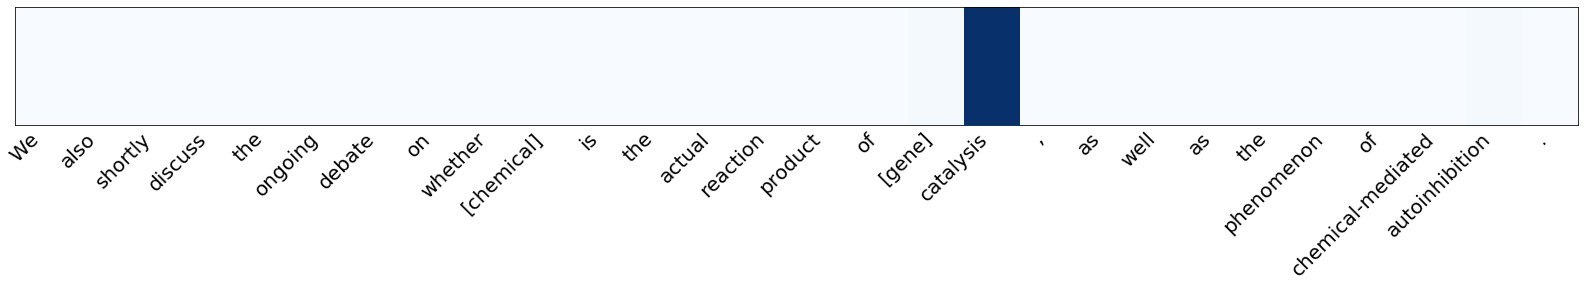

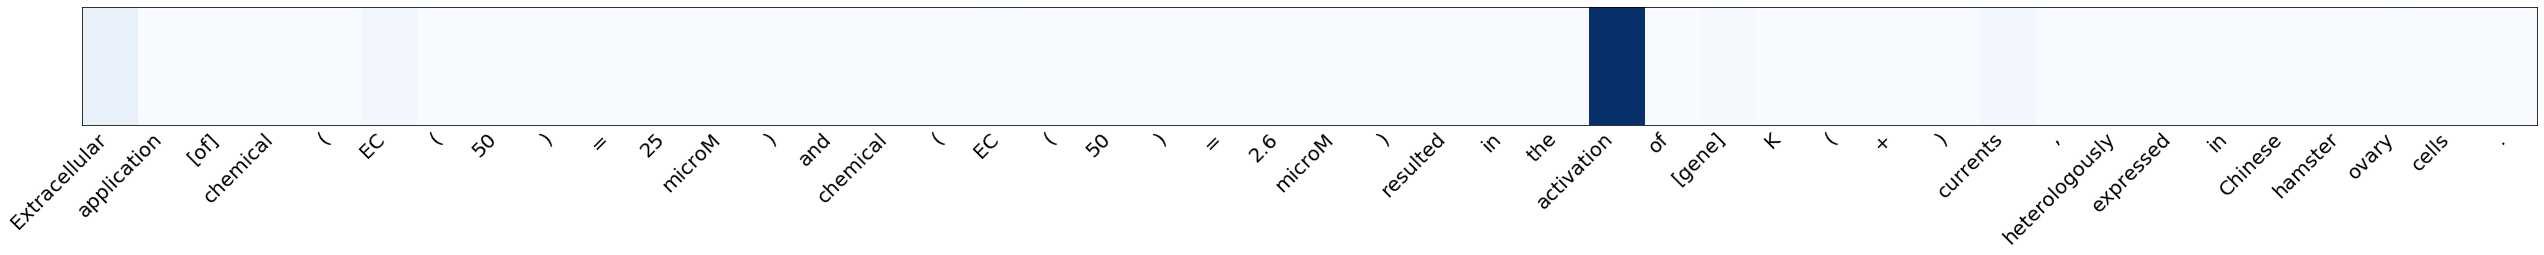

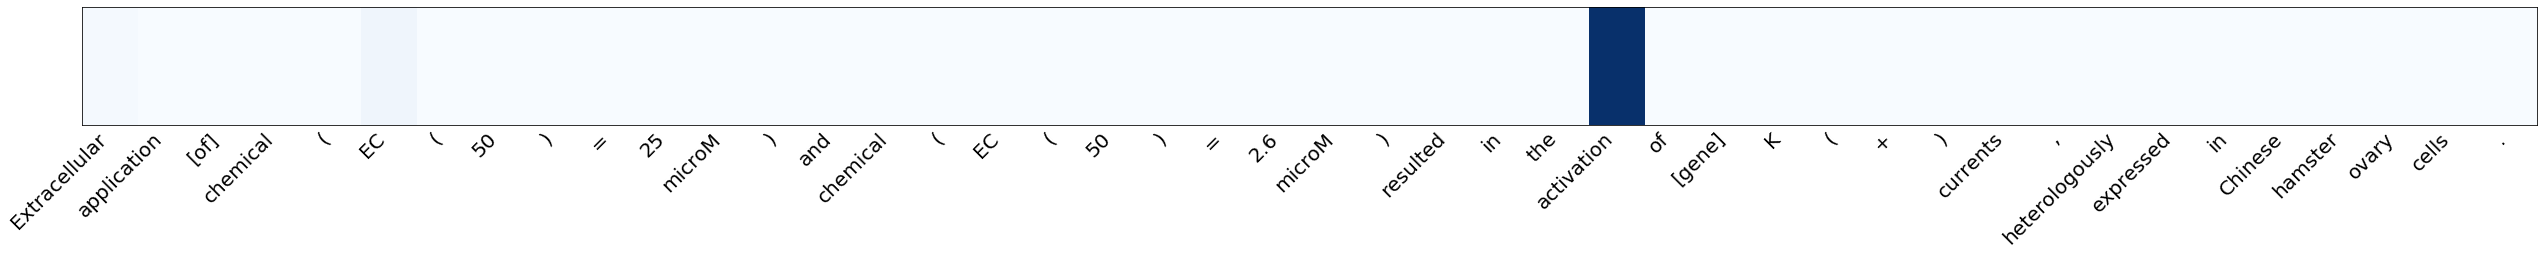

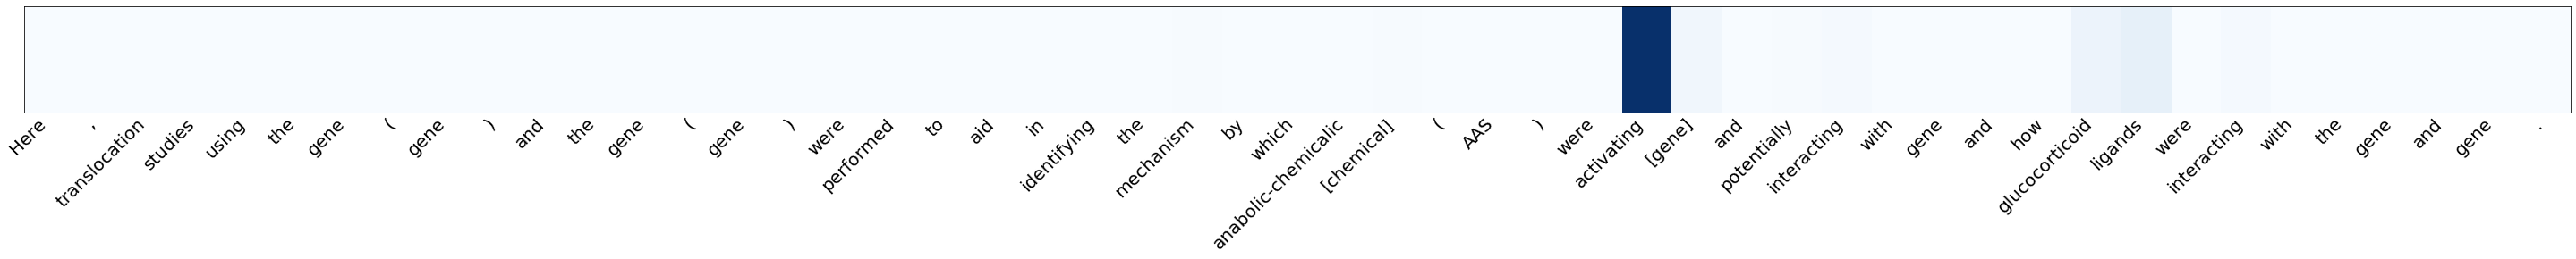

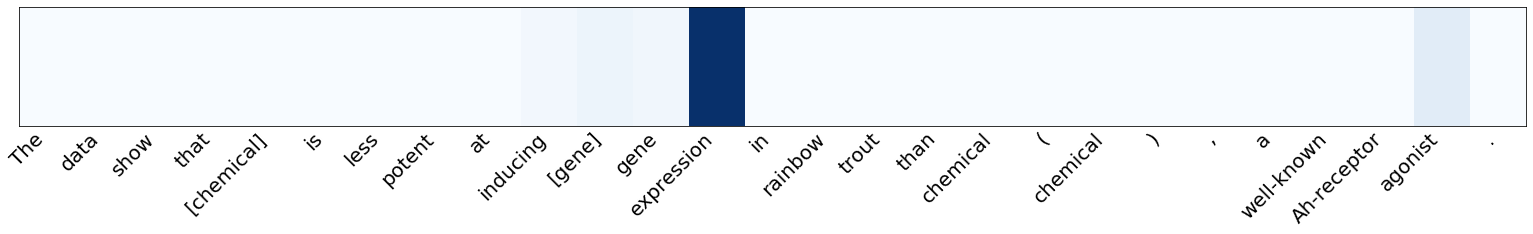

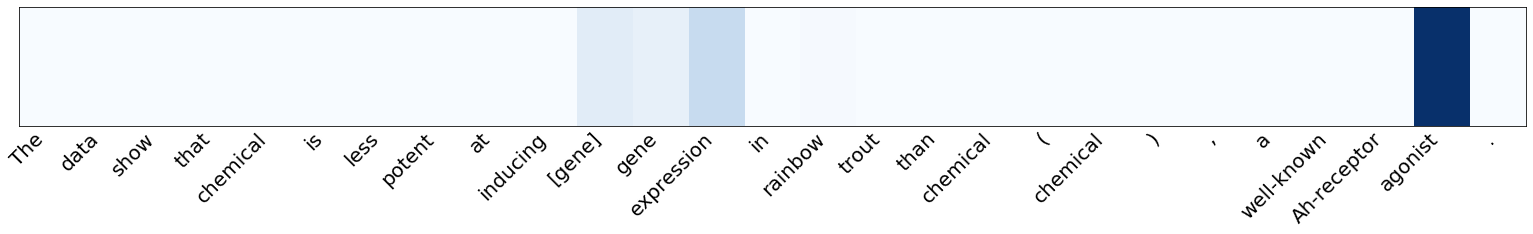

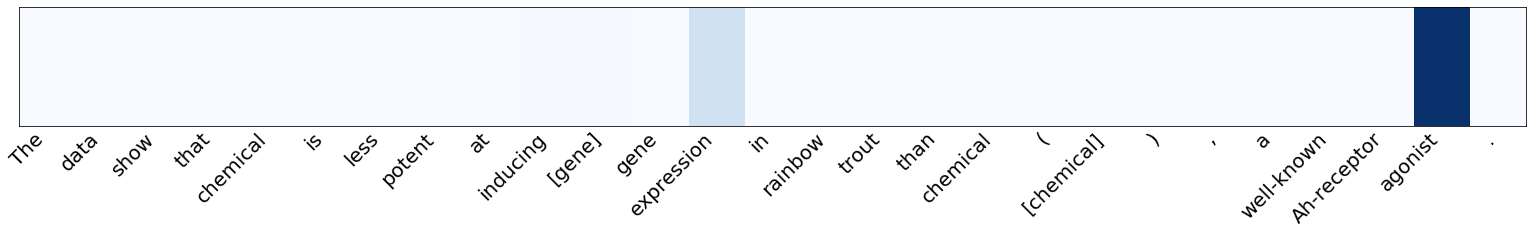

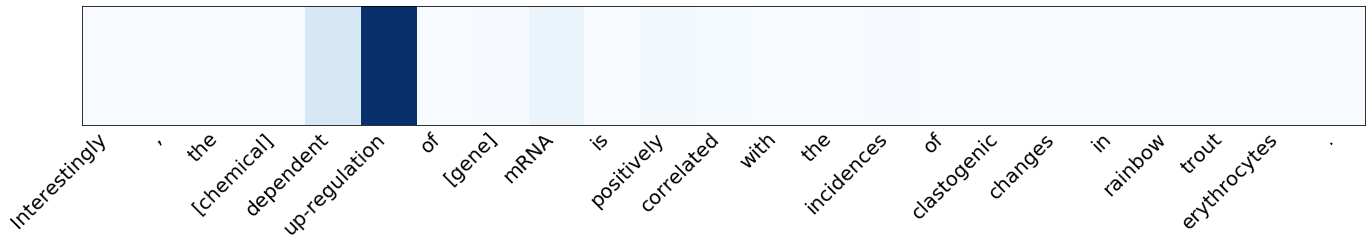

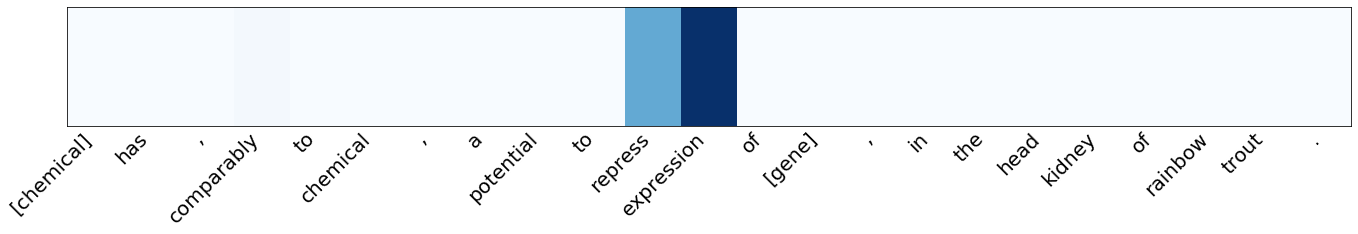

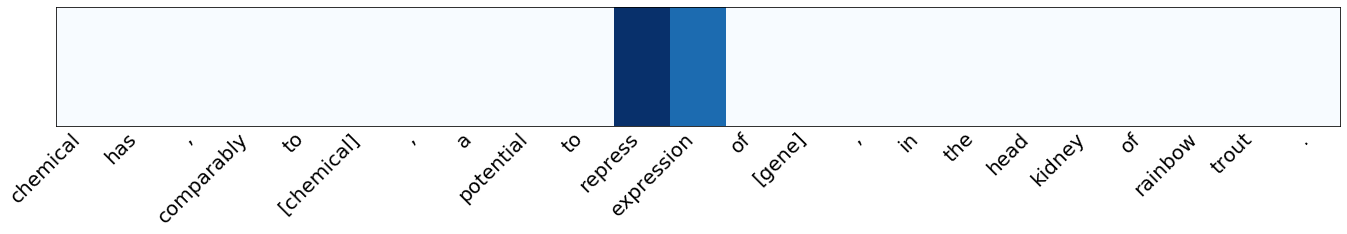

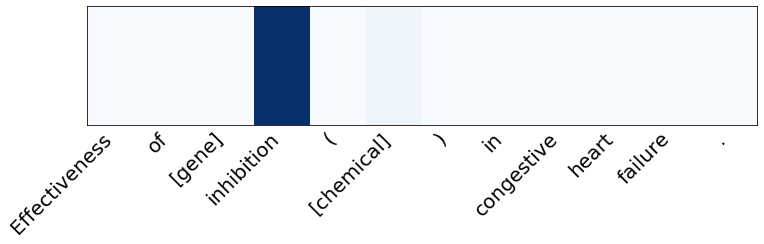

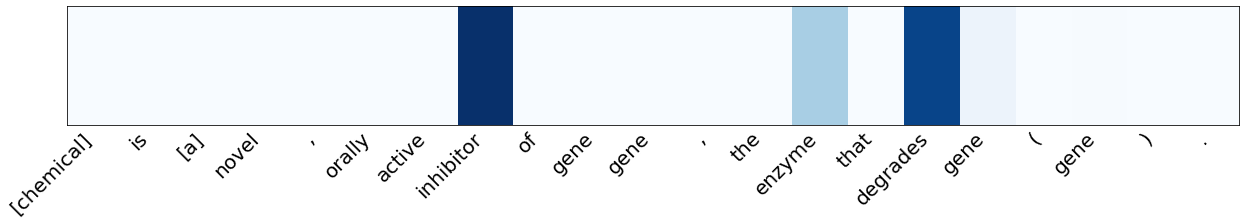

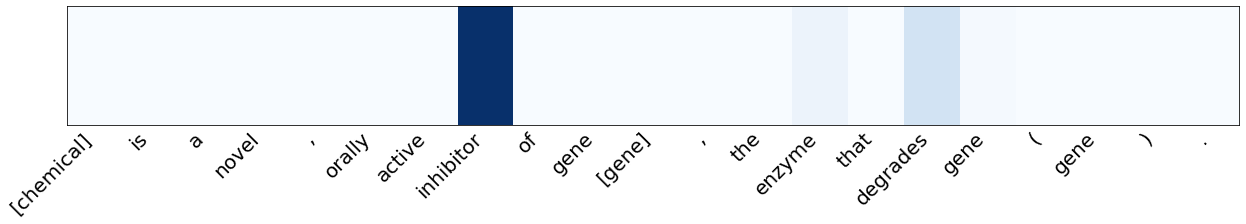

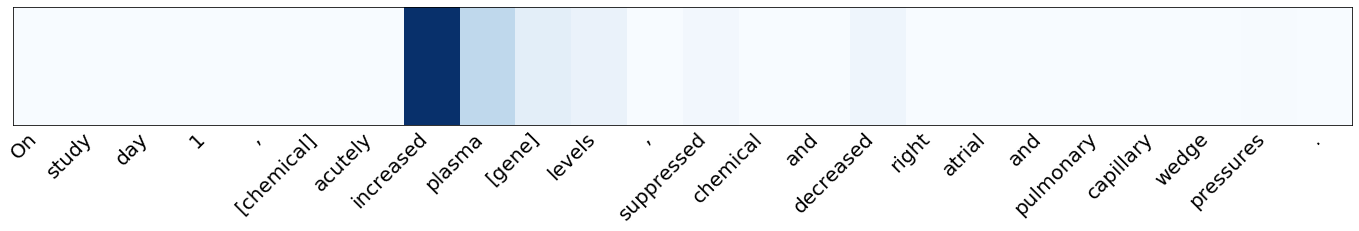

In [10]:
N = 100


for sent_idx in range(N):
    
    rel_instance = sent_splits[sent_idx]
    

    
    tokens = rel_instance[5].split()
    
    sent_len = len(tokens)
    if rel_instance[0] == 'NA':
        continue
        
    fig, ax = plt.subplots(figsize=(len(tokens), 5))

    chem_ent_tk_id = int(rel_instance[3])
    
    gene_ent_tk_id = int(rel_instance[4])
    
    values = get_att_weights(sent_idx)[:sent_len]
    
    # make tokens_len x 3 matrix for image plot. 
    x_matrix = np.array([values for _ in range(10)])

    ax.imshow(x_matrix, aspect='auto', interpolation='nearest', cmap='Blues', origin='upper')

    tk_labels = []
    for i, token in enumerate(tokens):
#         tk2plot = token.decode("utf-8", "ignore")       # for Python 2.7
        tk2plot = token          
        if i == chem_ent_tk_id or i == gene_ent_tk_id :
            tk2plot = "[%s]" % tk2plot
        
        tk_labels.append(tk2plot)
            
    tick_marks = np.arange(sent_len)
    plt.xticks(tick_marks, tk_labels, rotation=45, fontsize=20, ha='right')
    ax.set_yticklabels([])
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    fig.subplots_adjust(bottom=.55)
    # plt.savefig('output/att_vis/%d.png' % sent_idx)
    